Kaggle nickname - Sly RezZ

### Задание для курсового проекта <a class='anchor' id='course'>

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 10.01.21
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 

# Импорты библиотек и загрузка данных

## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import random
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

In [2]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках

## Загрузка данных

In [3]:
TRAIN_DATASET_PATH = pd.read_csv('Data/train.csv')
TEST_DATASET_PATH = pd.read_csv('Data/test.csv')

In [4]:
train_df = TRAIN_DATASET_PATH
test_df = TEST_DATASET_PATH

In [5]:
train_df.shape[1] - 1 == test_df.shape[1]

True

## Используемые функции

In [6]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [7]:
# Изменение типа столбцов в указанном df на строковый
def to_Str(df_, list):
    for i in list:
        df_[i] = df_[i].astype(str)

In [8]:
#обработка типов данных
def reduce_mem_usage(df): 
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        self.this_time = None
        self.districts_healthcare = None
        
    def fit(self, df_):
        self.medians = df_.median()
        self.kitchen_square_quantile = df_['KitchenSquare'].quantile(.975)
        self.this_time = datetime.now().year
        self.districts_healthcare = df_.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
    
    def transform(self, df_):  
        
        # корректировка года
        df_['HouseYear_outlier'] = 0
        this_time = datetime.now().year
        df_.loc[df_['HouseYear'] > this_time, 'HouseYear_outlier'] = 1
        df_.loc[df_['HouseYear'] > this_time, 'HouseYear'] = this_time 
        
        # корректировка комнат
        df_['Rooms_outlier'] = 0
        df_.loc[(df_['Rooms'] == 0) | (df_['Rooms'] >=6), 'Rooms_outlier'] = 1
        df_.loc[df_['Rooms'] == 0, 'Rooms'] = 1
        df_.loc[df_['Rooms'] >= 6, 'Rooms'] = df_['Rooms'].median() 
        
        # корректировка  площади        
        df_['Square_outlier'] = 0
        df_.loc[(df_['Square'] > 300),  'Square_outlier'] = 1 
        df_.loc[df_['Square'] > 300, 'Square'] = df_.loc[df_['Square'] > 300, 'Square'] / 10
        df_.loc[df_['Square'] > 300, 'Square'] = df_.loc[df_['Square'] > 300, 'Square'] / 10
        
        # корректировка плоащади кухни        
        df_['KitchenSquare'].quantile(.975), df_['KitchenSquare'].quantile(.025)
        condition = (df_['KitchenSquare'].isna()) | (df_['KitchenSquare'] > df_['KitchenSquare'].quantile(.975))    
        df_.loc[condition, 'KitchenSquare'] = df_['KitchenSquare'].median()
        df_.loc[df_['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    
        # корректировка жилой площади
        df_['LifeSquare_outlier'] = 0
        df_.loc[(df_['LifeSquare'] > 300),  'LifeSquare_outlier'] = 1
        df_.loc[df_['LifeSquare'] > 300, 'LifeSquare'] = df_.loc[df_['LifeSquare'] > 300, 'LifeSquare'] / 10 
        df_.loc[df_['LifeSquare'] > 300, 'LifeSquare'] = df_.loc[df_['LifeSquare'] > 300, 'LifeSquare'] / 10
        df_.loc[df_['LifeSquare']>df_['Square'], \
                     'LifeSquare'] = df_['Square'] - df_['KitchenSquare'] - 3
        df_[df_['LifeSquare']>df_['Square']]
        
        # корректировка этажности дома и этажей квартир
        df_['HouseFloor_outlier'] = 0
        df_.loc[df_['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df_.loc[df_['Floor'] > df_['HouseFloor'], 'HouseFloor_outlier'] = 1
        df_.loc[df_['HouseFloor'] == 0, 'HouseFloor'] = df_['HouseFloor'].median()
        floor_outliers = df_.loc[df_['Floor'] > df_['HouseFloor']].index
        df_.loc[floor_outliers, 'Floor'] = df_.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))
        
        # корректировка пропусков
        df_['LifeSquare_nan'] = 0
        df_.loc[df_['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        df_.loc[df_['LifeSquare'].isnull(), 'LifeSquare'] = df_['LifeSquare'].median()
        df_['Healthcare_1_nan'] = 0
        df_.loc[df_['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        df_.loc[df_['Healthcare_1'].isnull(), 'Healthcare_1'] = df_['Healthcare_1'].median()  
        
        # Привидение категорий к бинарным признакам
        df_.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df_.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df_.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # заполняем Healthcare_1, опираясь на DistrictId (если естьв районе)
        df_.loc[df_['Healthcare_1'].isna(), 'Healthcare_1'] = df_['DistrictId'].map(self.districts_healthcare)
        df_['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        q_max = np.quantile(df_['Healthcare_1'], q=0.9)
        df_['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        # убираем Id
       # df_.drop(['Id'], axis=1, inplace=True)
        
        # заполнение любых пропусков
        df_.fillna(self.medians, inplace=True)
        
        return df_    
        
        

In [10]:
class FeatureGenerator2():
    
    def __init__(self):
        self.district_size = None
        self.floor_max = None
        self.house_year_max = None
        self.med_price_by_floor_year = None
        self.med_price_by_district = None
        self.districts_median_year = None
        #self.districts_density = None

        
    def fit(self, X, y = None):
        X = X.copy()
        
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        self.districts_median_year = X.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        #self.districts_density = X.groupby(['DistrictId'])['Square'].agg('median').to_dict() 
        
        
        df = X.copy() 
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
        
    def transform(self, X):
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1       
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat                                             

        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        X['DistrictYear'] = X['DistrictId'].map(self.districts_median_year)
        self.median_district_year = X['DistrictYear'].median()
        X['DistrictYear'].fillna(self.median_district_year, inplace=True)
        
        #X['DistrictDensity'] = X['DistrictId'].map(self.districts_density)


        
        return X
    
    
    def floor_to_cat(self, X):
        X['floor_cat'] = 0
        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
        return X
     
    def year_to_cat(self, X):
        X['year_cat'] = 0
        X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
        return X

# EDA \ Работа с данными

### Имеющиеся данные:
* 'Id' - id объекта
* 'DistrictId' - id района
* 'Rooms' - кол-во комнат
* 'Square' - площадь
* 'LifeSquare' - жилая площадь
* 'KitchenSquare - площадь кухни
* 'Floor' - этаж
* 'HouseFloor' - этажность дома
* 'HouseYear' - год постройки дома
* 'Ecology_1' - экологические показатели
* 'Ecology_2' - экологические показатели
* 'Ecology_3' - экологические показатели
* 'Social_1' - социальнные показатели
* 'Social_2' - социальнные показатели
* 'Social_3' - социальнные показатели
* 'Healthcare_1' - показатели местности связанные с охраной здоровья
* 'Helthcare_2' - показатели местности связанные с охраной здоровья
* 'Shops_1' - показатели связанные с наличием магазинов и торг.центров
* 'Shops_2' - показатели связанные с наличием магазинов и торг.центров
* 'Price' - Цена

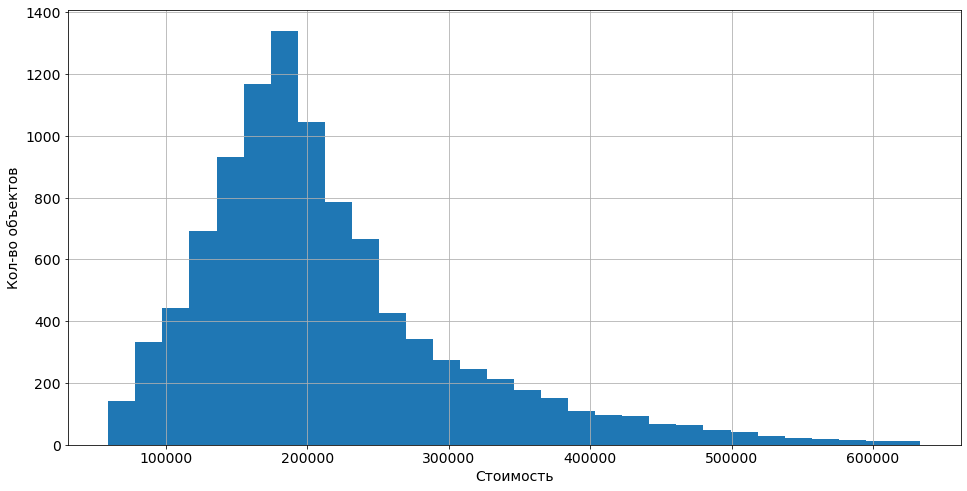

In [11]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Кол-во объектов')
plt.xlabel('Стоимость')

plt.show()

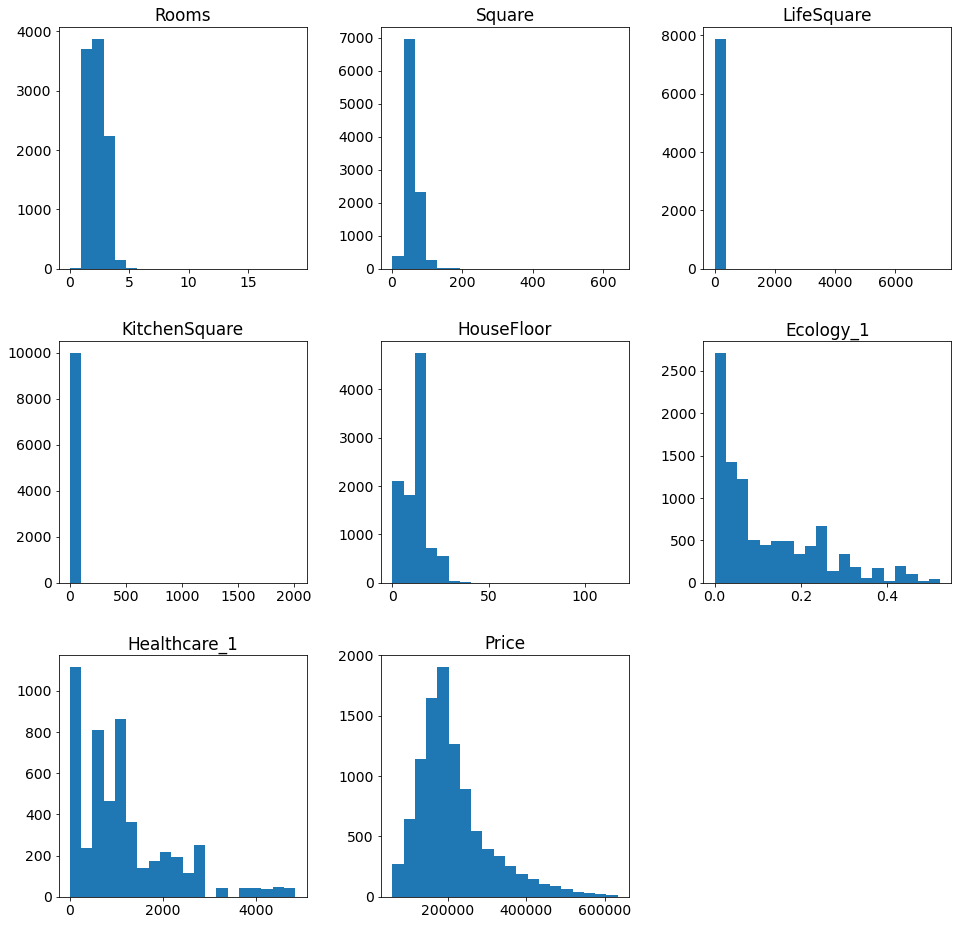

In [12]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

* Обратил внимание, что LifeSquare и Healthcare_1 имеют не заполненные поля

### Оптимизация типов данных и используемой памяти

In [15]:
to_Str(train_df, ('Id','DistrictId'))
to_Str(test_df, ('Id','DistrictId'))

In [16]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


In [17]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.39 MB
Decreased by 46.4%


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  category
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [19]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [20]:
features_gen = FeatureGenerator2()
features_gen.fit(train_df)
train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

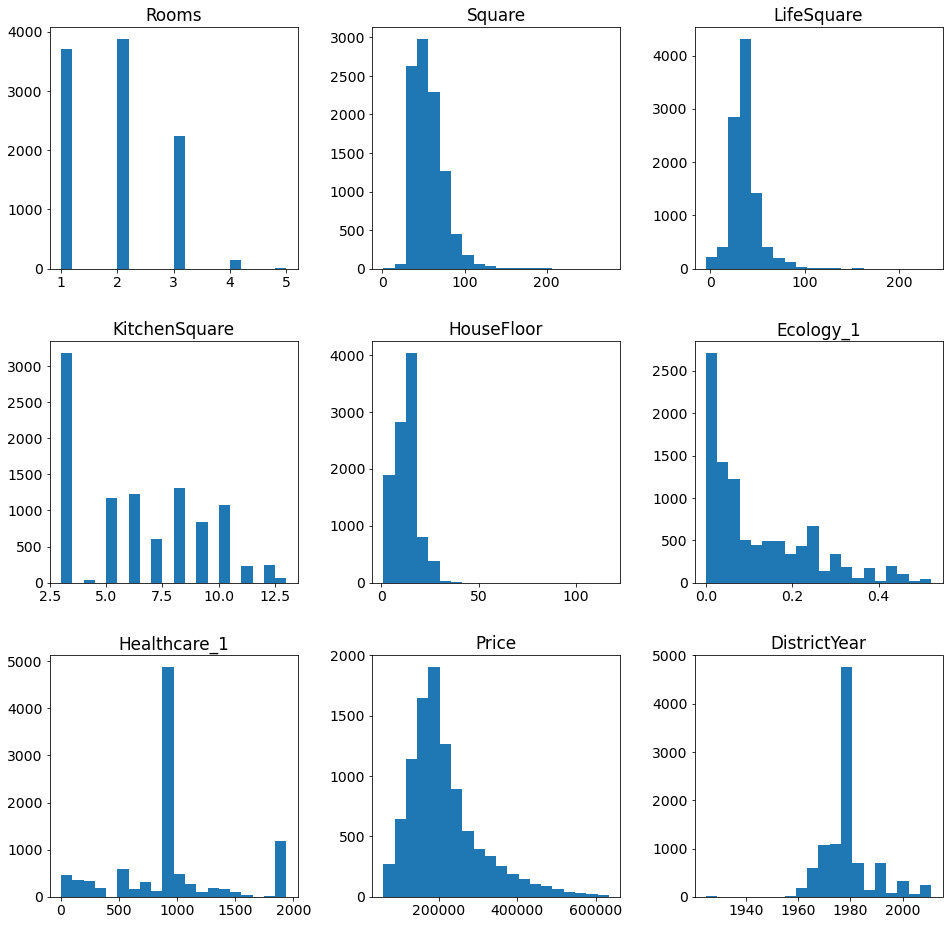

In [21]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])

df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

## Модельки

In [22]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)

In [23]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.859777935847934
0.7554685735109776


In [24]:
submit = pd.read_csv('Data/sample_submission.csv')
predictions = gb_model.predict(test_df)
submit['Price'] = predictions
submit.to_csv('gb_model_submit.csv', index=False)

In [25]:
gb_model2 = GradientBoostingRegressor(n_estimators=100, max_depth=7, random_state=21,max_features=15)


gb_model2.fit(X_train, y_train)


y_train_preds = gb_model2.predict(X_train)
y_test_preds = gb_model2.predict(X_test)

print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.9284859158107671
0.7483694519034636


In [26]:
submit = pd.read_csv('Data/sample_submission.csv')
predictions = gb_model2.predict(test_df)
submit['Price'] = predictions
submit.to_csv('gb_model2_submit.csv', index=False)

In [27]:
gb_model3 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model3.fit(X_train, y_train)


y_train_preds = gb_model3.predict(X_train)
y_test_preds = gb_model3.predict(X_test)

print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8993940414306806
0.7399593435855478


In [28]:
submit = pd.read_csv('Data/sample_submission.csv')
predictions = gb_model3.predict(test_df)
submit['Price'] = predictions
submit.to_csv('gb_model3_submit.csv', index=False)